# DNA Damage model formation & Prediction

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pycytominer
from pycytominer.consensus import modz
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_sample_weight

In [193]:
warnings.filterwarnings(action = 'ignore')

## 1. Preparing Cell Painting Data & Cell Health Data

### Load IDR-0080 Data & Cell Health Data
### Reference : https://pubmed.ncbi.nlm.nih.gov/33534641/

In [194]:
x_df = pd.read_csv('cell_painting_modz.tsv', sep = '\t')
x_meta = x_df.iloc[:, :3]
x_df = x_df.iloc[:, 3:]

y_all_df = pd.read_csv('cell_health_modz.tsv', sep = '\t')
y_df = y_all_df['cc_all_n_spots_h2ax_per_nucleus_area_mean']

### Load Chemical Annotation Data
### Reference : https://gigadb.org/dataset/100351

In [195]:
# Chemical annotation 
chem_dat = pd.read_csv('chemical_annotations.csv')
chem_dat

,BROAD_ID,CPD_NAME,CPD_NAME_TYPE,CPD_SAMPLE_ID,DOS_LIBRARY,SOURCE_NAME,CHEMIST_NAME,VENDOR_CATALOG_ID,CPD_SMILES,USERCOMMENT
0,BRD-A56675431-001-04-0,altizide,INN,SA82748,NaN,Prestwick Chemical Inc.,NaN,Prestw-721,NS(=O)(=O)c1cc2c(NC(CSCC=C)NS2(=O)=O)cc1Cl,NaN
1,BRD-A51829654-001-01-4,"BRL-15,572",common,SA82481,NaN,Biomol International Inc.,NaN,AC-536,OC(CN1CCN(CC1)c1cccc(Cl)c1)C(c1ccccc1)c1ccccc1,NaN
2,BRD-K04046242-001-03-6,equilin,primary-common,SA82922,NaN,Prestwick Chemical Inc.,NaN,Prestw-850,C[C@]12CC[C@H]3C(=CCc4cc(O)ccc34)[C@@H]1CCC2=O,NaN
3,BRD-K16508793-001-01-8,diazepam,INN,SA59660,NaN,MicroSource Discovery Systems Inc.,NaN,1900003,CN1c2ccc(Cl)cc2C(=NCC1=O)c1ccccc1,NaN
4,BRD-K09397065-001-01-6,SR 57227A,to-be-curated,SA82504,NaN,Biomol International Inc.,NaN,AC-561,NC1CCN(CC1)c1cccc(Cl)n1,NaN
...,...,...,...,...,...,...,...,...,...,...
30611,BRD-K47092271-001-01-7,BRD-K47092271,BROAD_CPD_ID,SA799574,Benzofuran Library,Broad Institute of MIT and Harvard,NaN,NaN,COCC(=O)Nc1ccc2O[C@@H]3[C@@H](C[C@H](CC(=O)NCC...,NaN
30612,BRD-K30358777-001-01-0,BRD-K30358777,BROAD_CPD_ID,SA800605,Benzofuran Library,Broad Institute of MIT and Harvard,NaN,NaN,COc1ccc(CNC(=O)C[C@@H]2C[C@H]3[C@H](Oc4ccc(NC(...,NaN
30613,BRD-K32423836-001-01-9,BRD-K32423836,BROAD_CPD_ID,SA799806,Benzofuran Library,Broad Institute of MIT and Harvard,NaN,NaN,COCCNC(=O)C[C@H]1C[C@@H]2[C@@H](Oc3ccc(NC(=O)C...,NaN
30614,BRD-K28250273-001-01-2,BRD-K28250273,BROAD_CPD_ID,SA1482018,Azetidine Nitrile Full Library,Broad Institute of MIT and Harvard,NaN,NaN,OC[C@H]1[C@H]([C@H](C#N)N1C(=O)Nc1cccc(F)c1)c1...,NaN


# 2. Validation dataset preprocessing

## Load sample validation dataset 
### cpg0012's plate 24306
### Reference : https://gigadb.org/dataset/100351

In [196]:
# Load validation datasets
x_val_dat = pd.read_csv('mean_well_profiles.csv') # plate 24306


# Follow idr0080 normalization ways
x_val_norm_dat = pycytominer.normalize(
    profiles = x_val_dat,
    features = 'infer',
    method = 'mad_robustize',
    samples = 'Metadata_solvent == "DMSO"'
)

# Follow idr0080 feature selection ways
x_val_norm_dat = pycytominer.feature_select(
    profiles = x_val_norm_dat,
    features = 'infer',
    operation = [
        'drop_na_columns',
        'blocklist',
        'variance_threshold',
        'drop_outliers'
    ]
)

#x_val_norm_dat = x_val_norm_dat.query('Metadata_broad_sample != "DMSO"')

# Devied metadata & cell painting data
x_val_meta = x_val_norm_dat.iloc[:, :17] # 17 
x_val_df = x_val_norm_dat.iloc[:, 17:] 

In [197]:
# MODZ scaling for validaiton dataset
x_val_df['Metadata_broad_sample'] = x_val_meta['Metadata_broad_sample']

x_df_modz = modz(
    x_val_df,
    replicate_columns = ['Metadata_broad_sample'],
    precision = 5
)

x_df_modz = x_df_modz.iloc[:, 1:]
x_df_modz

,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MeanRadius,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,0.077826,2.210831,3.185245,2.351784,-3.453662,-0.665763,2.294685,2.477498,1.116056,1.192810,...,0.435456,-0.910246,-1.267630,-1.214799,0.464848,-0.088872,-0.077549,-0.979193,-1.388224,-1.092092
1,-1.037678,0.374717,0.508243,0.848381,0.469262,-0.761764,1.928568,1.955454,2.084137,2.281973,...,5.037798,-0.585354,0.822544,0.237205,1.613462,1.588054,1.555721,2.031896,1.292912,1.353086
2,-0.674491,-2.435661,-0.209134,0.255651,0.427650,0.870017,0.800537,0.798476,1.133007,1.396999,...,4.899822,-0.405544,0.373237,-0.185714,0.569231,1.374408,1.334015,1.174123,1.451945,1.272649
3,-0.882026,0.449661,2.906479,1.862581,-1.666906,0.203821,2.207463,2.244937,1.318162,1.334734,...,-0.044538,-0.601456,-0.323971,-0.541390,-0.374285,-0.487961,-0.348521,0.966598,0.823093,0.800769
4,-0.207536,-0.711962,1.603780,1.146239,-1.648947,-0.455139,1.295874,1.436188,0.650590,0.709270,...,0.316370,0.305549,0.588692,0.481053,-1.098381,-1.340394,-1.475020,0.173596,-0.069845,0.161734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,1.608401,-0.674491,1.199265,1.494756,-0.931037,-0.626963,0.706344,0.685465,0.223367,0.200746,...,-0.790790,-0.754632,-0.827323,-0.692013,-1.255622,-0.468507,-0.699628,0.675044,-0.038565,0.393632
317,1.348982,-0.149887,1.596471,1.353023,-1.611648,-0.813942,0.333514,0.401696,-0.387185,-0.148372,...,-0.629000,-0.474736,-0.581660,-0.587504,-0.688760,-0.689443,-0.873527,-0.253329,-0.218745,-0.134691
318,-0.752317,1.648755,1.083539,0.337857,-1.263909,-0.239567,0.442785,0.395045,0.077920,0.124410,...,-1.282379,0.023325,-0.190828,-0.128193,-1.201422,-0.945536,-0.872981,-0.399807,0.066885,0.031387
319,-1.193330,-0.149887,0.492029,0.395970,-0.860426,-2.234476,0.239986,0.167619,-0.406153,-0.288282,...,-0.432186,-0.232994,-0.361480,-0.427102,-1.253156,-0.619239,-0.444032,-0.350578,-0.635276,-0.625096


In [198]:
# Check unique compound in validation dataset
compound = x_val_meta['Metadata_broad_sample'].unique()
len(compound)

321

# 3. Setting same x features number for x data & validation data 

In [199]:
# Filter except same features in idr0080 & cpg0012
x_cols = x_df.columns
x_val_cols = x_df_modz.columns

filt_cols = x_cols.intersection(x_val_cols)

x_df = x_df[filt_cols]
x_val_df = x_df_modz[filt_cols]

display(x_df)
display(x_val_df)

,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_5_0
0,-0.180160,-0.155631,0.014646,0.188053,1.231056,0.031064,-0.585477,0.467976,0.254203,0.129446,...,0.882859,0.841687,0.339831,0.562585,0.879950,0.904785,0.923143,0.944998,0.984938,0.961945
1,0.370572,-0.247842,-0.030773,0.433778,0.062456,0.266860,0.838679,-0.467417,0.340793,-0.024450,...,0.513820,0.344554,0.134318,0.018933,0.359496,0.557998,0.504751,0.407462,0.522251,0.519441
2,-0.360905,0.794740,0.743296,-0.438752,0.827288,-0.728499,-0.422394,-0.147624,0.083870,-0.160722,...,-0.456539,0.373750,-0.111184,-0.042733,-0.840771,-0.536215,-0.497296,-0.748232,-0.515240,-0.526734
3,0.262450,0.480421,0.821096,-0.337898,0.054479,-0.662314,0.067979,0.025010,0.158138,-0.342062,...,0.115466,0.186411,0.249292,0.688435,-0.521766,0.124801,0.063444,-0.560178,-0.062851,0.026056
4,-0.110264,-0.074895,0.569377,0.571678,0.976504,-1.111947,1.348542,0.584906,-3.128483,-2.324773,...,0.154802,2.975785,1.128414,-0.638839,0.753884,0.808944,0.594059,0.674015,0.140325,0.417465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.446930,0.247953,0.331462,-0.228694,0.648857,-0.394799,-0.477804,-0.203016,0.387554,0.485502,...,0.305814,0.952718,0.697652,0.087784,0.266722,0.254346,0.367875,0.191115,0.220894,0.257950
353,-0.500081,1.455427,1.153796,-1.395398,1.167778,-1.413069,-0.684198,-0.923160,-0.145706,-0.535382,...,-0.207834,-0.280317,-0.422648,-0.763835,-0.254697,-0.380000,-0.404530,-0.266026,-0.341998,-0.287431
354,0.407771,0.719510,0.691270,-0.999921,0.701489,-0.965601,-0.937154,-0.218680,0.145943,-0.149745,...,0.011171,-0.575574,-0.272102,-0.101586,-0.117305,-0.083261,-0.085342,-0.213054,-0.126822,-0.101668
355,0.063720,-0.255658,0.075113,0.999995,0.251456,0.237111,0.342004,0.084765,0.957639,-0.562746,...,0.766721,0.518347,1.450779,1.421830,1.483743,0.639279,0.614153,1.624128,0.523767,0.603819


,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_Extent,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_0_0,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_3,...,Nuclei_Texture_SumEntropy_DNA_5_0,Nuclei_Texture_SumEntropy_ER_5_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumEntropy_RNA_5_0,Nuclei_Texture_SumVariance_AGP_5_0,Nuclei_Texture_SumVariance_DNA_10_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_AGP_5_0,Nuclei_Texture_Variance_DNA_10_0,Nuclei_Texture_Variance_DNA_5_0
0,2.210831,3.185245,2.351784,-3.453662,-0.725301,-3.038433,-1.452215,-2.490358,0.215098,-1.662977,...,0.198737,0.034115,-0.401413,-0.824950,-1.672145,0.149615,0.237127,-1.458522,0.694766,0.435456
1,0.374717,0.508243,0.848381,0.469262,-1.271219,-0.539449,0.406587,-0.023074,1.652274,-0.640034,...,4.425595,2.762427,2.268049,2.408099,0.904769,5.415348,5.487572,-0.283376,5.591977,5.037798
2,-2.435661,-0.209134,0.255651,0.427650,-2.686150,-0.130634,1.142348,0.456705,-0.323134,0.581353,...,4.648500,3.087588,2.152137,2.091563,1.593579,4.659855,5.262547,0.421885,5.430637,4.899822
3,0.449661,2.906479,1.862581,-1.666906,-0.824188,-2.302488,-1.109963,-2.943595,-0.220954,-0.420657,...,-0.154235,-0.377437,-0.067547,0.259038,-1.086147,0.141180,0.004284,-1.786379,0.134911,-0.044538
4,-0.711962,1.603780,1.146239,-1.648947,0.842747,-1.575018,-1.207895,-1.349442,0.750506,0.339709,...,-0.282950,0.060413,-0.860123,-1.068675,-1.294816,-0.047170,0.130027,-1.514355,0.615017,0.316370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,-0.674491,1.199265,1.494756,-0.931037,-0.994754,-0.898056,-1.352128,-0.530739,0.970324,-1.629309,...,-1.003564,-0.769914,-0.233639,-0.071734,-1.620532,-1.711346,-1.231005,-1.975245,-0.534774,-0.790790
317,-0.149887,1.596471,1.353023,-1.611648,0.717217,-1.335799,-0.802091,-1.559356,-0.381397,-1.169557,...,-0.524293,-0.705811,0.039353,-0.107175,-1.225908,-0.488064,-0.456405,-1.429988,-0.598059,-0.629000
318,1.648755,1.083539,0.337857,-1.263909,-0.350779,-0.783795,0.771543,-1.129389,-0.967943,0.542581,...,-0.846619,-0.021072,-0.366242,-0.222260,-0.555017,-0.321643,-0.682356,-0.694217,-1.332090,-1.282379
319,-0.149887,0.492029,0.395970,-0.860426,-1.197453,-0.479067,-0.033196,-0.507453,0.343849,0.108738,...,-0.108487,-0.024398,0.141070,0.016915,-0.582637,0.489818,0.167522,-1.160208,-0.503925,-0.432186


# 4. Cell Health Labeling for Classification Model

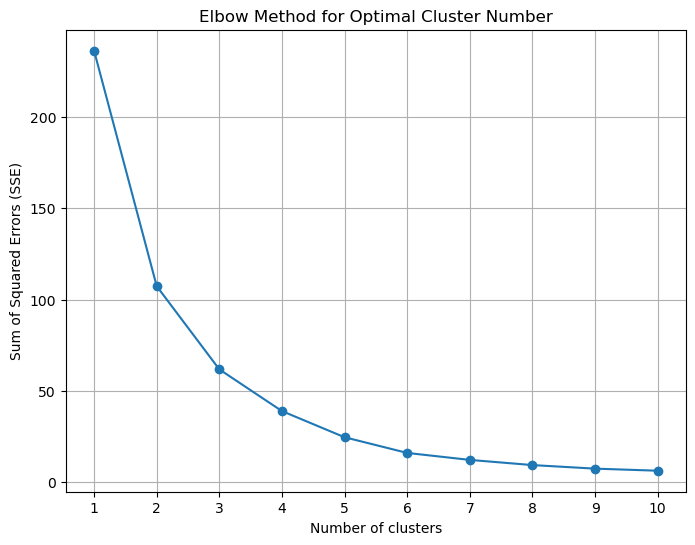

In [200]:
from sklearn.cluster import KMeans

# Create an array to store SSE values for different cluster numbers
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state=42)
    kmeans.fit(y_df.values.reshape(-1, 1))
    sse.append(kmeans.inertia_)


# Plotting the elbow curve
plt.figure(figsize = (8,6))
plt.plot(range(1, 11), sse, marker = 'o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.savefig('Elbow Method.png')
plt.show()

In [201]:
# y_df Categorized

kmeans = KMeans(n_clusters = 6, random_state = 42)
y_clusters = kmeans.fit_predict(y_df.values.reshape(-1, 1))

y_df_binarized = y_clusters

In [202]:
from collections import Counter

counter = Counter(y_df_binarized)
counter

Counter({0: 117, 3: 94, 5: 90, 2: 38, 1: 13, 4: 5})

In [748]:
#np.where(y_df_binarized == 5)

(array([  1,   2,   5,   7,   9,  15,  22,  24,  25,  28,  32,  40,  41,
         43,  53,  55,  57,  58,  59,  66,  67,  82,  87,  90,  94,  96,
         98, 107, 111, 112, 113, 124, 126, 128, 133, 134, 136, 143, 152,
        165, 169, 171, 172, 173, 176, 185, 187, 194, 195, 197, 198, 199,
        201, 209, 213, 222, 230, 235, 238, 242, 244, 246, 247, 261, 262,
        265, 270, 281, 285, 289, 290, 292, 293, 294, 295, 302, 307, 316,
        317, 318, 323, 325, 326, 328, 333, 334, 339, 340, 343, 351],
       dtype=int64),)

In [799]:
#y_df.sort_values(ascending = False).to_excel('y_df.xlsx')

In [203]:
# Remapping
mapping = {4: 0, 0: 0, 3: 0, 5: 0, 2: 1, 1: 1} # 0 : Low, 1: High
y_df_binarized = np.vectorize(mapping.get)(y_df_binarized)

In [204]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

# 5. Oversampling (SMOTE)

In [205]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df_binarized, test_size = 0.3, random_state = 42, shuffle  = True)


# Over Sampleing
smote = SMOTE(random_state = 42)

X_train_s, y_train_s = smote.fit_resample(X_train, y_train)

# Data Flatten
y_train_s = np.ravel(y_train_s)
y_test = np.ravel(y_test)


# 6. Classification Model Formation & Check Accuracy

# Oversampling (o) / Model weights (o)

In [168]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

class_weights = {0: 3.0, 1: 10.0}

# Models Dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight= class_weights),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, class_weight= class_weights),
    'LogisticRegression': LogisticRegression(random_state=42, class_weight= class_weights),
    'SGDClassifier': SGDClassifier(random_state=42, class_weight= class_weights),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight= class_weights)
}

# models parameters setting
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1','l2']
    },
    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l1', 'l2']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'GaussianNB': {}, 
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

# Best Parameter searching
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_s, y_train_s)
    
    # Show Best Parameters
    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best Cross-validation Accuracy for {model_name}: {grid_search.best_score_:.4f}")
    
    # Prediction with optimal model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store ersults in the dictionary
    results[model_name] = {
        'accuracy' : test_accuracy,
        'mse' : mse
    }
    
    # Assesment score present
    print(f"\nTest Accuracy for {model_name}: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("---------------------------------------")

# Accuracy 
print("\nTest Accuracy Results:")
for model_name, metrics in results.items():
    print(f"{model_name} Accuracy : {metrics['accuracy']: .4f}, MSE : {metrics['mse']: .2f}")

Training RandomForest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters for RandomForest:
{'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-validation Accuracy for RandomForest: 0.9086

Test Accuracy for RandomForest: 0.7870
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87        93
           1       0.32      0.47      0.38        15

    accuracy                           0.79       108
   macro avg       0.61      0.65      0.62       108
weighted avg       0.83      0.79      0.80       108

---------------------------------------
Training GradientBoosting...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters for GradientBoosting:
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-valid

# Oversampling (x) / Model Weights (o)

In [180]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Data Split
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df_binarized, test_size = 0.3, random_state = 42, shuffle  = True)

# Models Dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42, class_weight= class_weights),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42, class_weight= class_weights),
    'LogisticRegression': LogisticRegression(random_state=42, class_weight= class_weights),
    'SGDClassifier': SGDClassifier(random_state=42, class_weight= class_weights),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42, class_weight= class_weights)
}

# models parameters setting
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1','l2']
    },
    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l1', 'l2']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'GaussianNB': {}, 
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

# Best Parameter searching
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Show Best Parameters
    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best Cross-validation Accuracy for {model_name}: {grid_search.best_score_:.4f}")
    
    # Prediction with optimal model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store ersults in the dictionary
    results[model_name] = {
        'accuracy' : test_accuracy,
        'mse' : mse
    }
    
    # Assesment score present
    print(f"\nTest Accuracy for {model_name}: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("---------------------------------------")

# Accuracy 
print("\nTest Accuracy Results:")
for model_name, metrics in results.items():
    print(f"{model_name} Accuracy : {metrics['accuracy']: .4f}, MSE : {metrics['mse']: .2f}")

Training RandomForest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters for RandomForest:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-validation Accuracy for RandomForest: 0.9639

Test Accuracy for RandomForest: 0.9815
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       104
           1       1.00      0.50      0.67         4

    accuracy                           0.98       108
   macro avg       0.99      0.75      0.83       108
weighted avg       0.98      0.98      0.98       108

---------------------------------------
Training GradientBoosting...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters for GradientBoosting:
{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-valida

# Oversampling(o) / Model Weights (x)

In [181]:
# Models Dictionary
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42),
    'SGDClassifier': SGDClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# models parameters setting
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf', 'poly']
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1','l2']
    },
    'SGDClassifier': {
        'alpha': [0.0001, 0.001, 0.01, 0.1],
        'penalty': ['l1', 'l2']
    },
    'KNeighbors': {
        'n_neighbors': [3, 5, 10],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'GaussianNB': {}, 
    'DecisionTree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2']
    }
}

# Best Parameter searching
results = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_s, y_train_s)
    
    # Show Best Parameters
    print(f"Best Parameters for {model_name}:")
    print(grid_search.best_params_)
    print(f"Best Cross-validation Accuracy for {model_name}: {grid_search.best_score_:.4f}")
    
    # Prediction with optimal model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store ersults in the dictionary
    results[model_name] = {
        'accuracy' : test_accuracy,
        'mse' : mse
    }
    
    # Assesment score present
    print(f"\nTest Accuracy for {model_name}: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("---------------------------------------")

# Accuracy 
print("\nTest Accuracy Results:")
for model_name, metrics in results.items():
    print(f"{model_name} Accuracy : {metrics['accuracy']: .4f}, MSE : {metrics['mse']: .2f}")

Training RandomForest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters for RandomForest:
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-validation Accuracy for RandomForest: 0.9249

Test Accuracy for RandomForest: 0.8333
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       104
           1       0.11      0.50      0.18         4

    accuracy                           0.83       108
   macro avg       0.54      0.67      0.54       108
weighted avg       0.95      0.83      0.88       108

---------------------------------------
Training GradientBoosting...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters for GradientBoosting:
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-valid

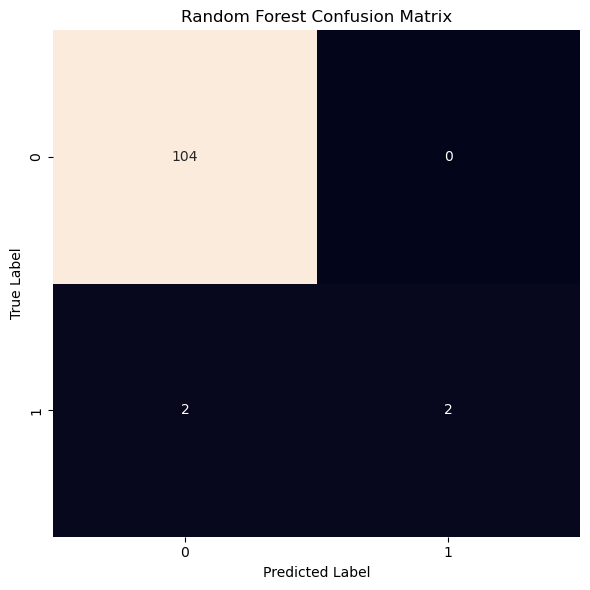

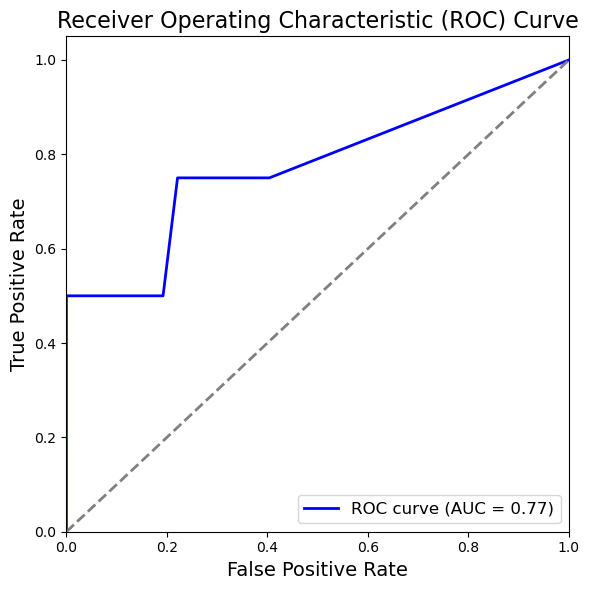

In [147]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns


# RandomForest Confusion Matrix
rf = RandomForestClassifier(max_depth=None, max_features='log2', min_samples_leaf= 1, min_samples_split=2, n_estimators = 100, random_state = 42)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

conf_matrix = confusion_matrix(y_test, rf_pred)

plt.figure(figsize = (6, 6))
sns.heatmap(conf_matrix, annot = True, cbar = False, fmt = '')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()

# RandomForest ROC Curve
rf_pred_prob = rf.predict_proba(X_test)[:, 1] 

fpr, tpr, _ = roc_curve(y_test, rf_pred_prob)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.legend(loc='lower right', fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.tight_layout()
plt.savefig('ROC_Curve.png', dpi=300)
plt.show()


In [148]:
val_pred = rf.predict(x_val_df)

np.where(val_pred != 0)

(array([308], dtype=int64),)

In [151]:
# Find Near Data
from sklearn.neighbors import NearestNeighbors

# Choose specific data
specific_data = x_val_df.iloc[[308], :] 

# NearestNeighbors
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(x_val_df)
distances, indices = nbrs.kneighbors(specific_data)

closet_data = x_val_df.iloc[indices[0]]


print(f'Selected Data Index: {specific_data.index[0]}')
print(f'Closest 5 Data Indices: {closet_data.index.tolist()}')

for idx in closet_data.index.tolist():
    value = x_val_meta.loc[idx, 'Metadata_broad_sample']
    print(chem_dat[chem_dat['BROAD_ID'] == value]['CPD_NAME'].tolist()) # 64 DMSO

Selected Data Index: 308
Closest 5 Data Indices: [308, 61, 179, 235, 287]
['IKK inhibitor VII']
['protein tyrosine phosphatase inhibitor IV']
['sericetin dimethyl ether']
['norfloxacin']
[]


## Classification Accuracy

# 7. Deep Learning Model Formation & Check Accuracy

In [190]:
from tensorflow.keras import regularizers


# Compute sample weights
class_weights_dict = {0: 3, 1: 10}
sample_weights = compute_sample_weight(class_weight = class_weights_dict, y = y_train_s)

# Setting same seed number
tf.random.set_seed(42)

# Model define
model = keras.Sequential([
    layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.01), input_shape = (X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01)),  
    layers.Dense(1, activation='sigmoid')
])

# Model Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 128)            │       102,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,769 (440.50 KB)

 Trainable params: 112,769 (440.50 KB)

 Non-trainable params: 0 (0.00 B)

# Oversampling(o) / Sample Weights(o)

In [77]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Early Stopping 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Best model save
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

tf.random.set_seed(42)
# Model FIT
history = model.fit(X_train_s, y_train_s,
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, checkpoint_callback],
                    sample_weight=sample_weights)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8974 - loss: 0.7704 - val_accuracy: 0.7963 - val_loss: 1.1710
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9330 - loss: 0.6752 - val_accuracy: 0.8519 - val_loss: 1.0285
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9601 - loss: 0.6127 - val_accuracy: 0.7778 - val_loss: 1.7690
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8971 - loss: 0.8323 - val_accuracy: 0.8056 - val_loss: 1.2368
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9515 - loss: 0.6244 - val_accuracy: 0.8333 - val_loss: 1.0932
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9467 - loss: 0.6270 - val_accuracy: 0.8519 - val_loss: 1.0048
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9678 - loss: 0.5602 - val_accuracy: 0.8704 - val_loss: 0.9555
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9713 - loss: 0.5303 - val_accuracy: 0.8889 - v

# Oversampliing(x) / Sample Weights (o)

In [189]:
from tensorflow.keras.callbacks import ModelCheckpoint


# Compute sample weights
class_weights_dict = {0: 3, 1: 10}
sample_weights = compute_sample_weight(class_weight = class_weights_dict, y = y_train)
# Early Stopping 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Best model save
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

tf.random.set_seed(42)
# Model FIT
history = model.fit(X_train, y_train,
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, checkpoint_callback],
                    sample_weight=sample_weights)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6493 - loss: 6.7645 - val_accuracy: 0.9630 - val_loss: 3.6906
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9729 - loss: 4.4947 - val_accuracy: 0.8796 - val_loss: 3.7133
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8773 - loss: 4.5064 - val_accuracy: 0.9444 - val_loss: 3.5664
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9322 - loss: 4.1707 - val_accuracy: 0.9630 - val_loss: 3.4117
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9702 - loss: 3.9242 - val_accuracy: 0.9537 - val_loss: 3.3487
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9561 - loss: 3.6830 - val_accuracy: 0.9444 - val_loss: 3.2381
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9789 - loss: 3.6198 - val_accuracy: 0.8889 - val_loss: 3.2483
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9273 - loss: 3.5973 - val_accuracy: 0.9630 - val_loss: 3.0512

# Oversampling(o) / Sample Weights(x)

In [191]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Early Stopping 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Best model save
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

tf.random.set_seed(42)
# Model FIT
history = model.fit(X_train_s, y_train_s,
                    epochs=100, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, checkpoint_callback])

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6827 - loss: 4.0048 - val_accuracy: 0.7037 - val_loss: 3.9478
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9052 - loss: 3.2835 - val_accuracy: 0.7870 - val_loss: 3.4067
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9135 - loss: 2.8094 - val_accuracy: 0.8333 - val_loss: 2.8534
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9696 - loss: 2.3568 - val_accuracy: 0.8333 - val_loss: 2.5714
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 2.0465 - val_accuracy: 0.7963 - val_loss: 2.7744
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9550 - loss: 1.8327 - val_accuracy: 0.8241 - val_loss: 2.1189
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9615 - loss: 1.6121 - val_accuracy: 0.8333 - val_loss: 2.0752
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9682 - loss: 1.4670 - val_accuracy: 0.8241 - 

## Deep Learning Model Results

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8642 - loss: 0.8903  
Test Accuracy of the Best Model: 0.8611
Test loss of the Best Model :  0.8834


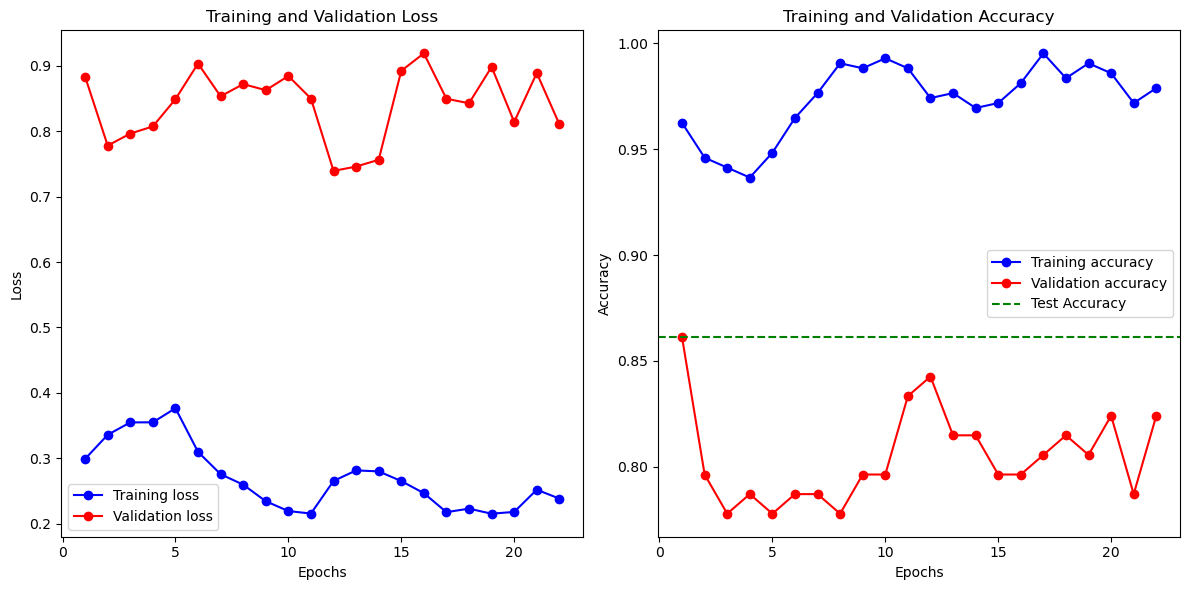

In [17]:
# Save Best Model
best_model = keras.models.load_model('best_model.keras')

# Test data evaluation
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

print(f'Test Accuracy of the Best Model: {test_accuracy:.4f}')
print(f'Test loss of the Best Model : {test_loss: .4f}')

# Assesment scores
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# plotting
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.axhline(y=test_accuracy, color='g', linestyle='--', label='Test Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('Deep learning results.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


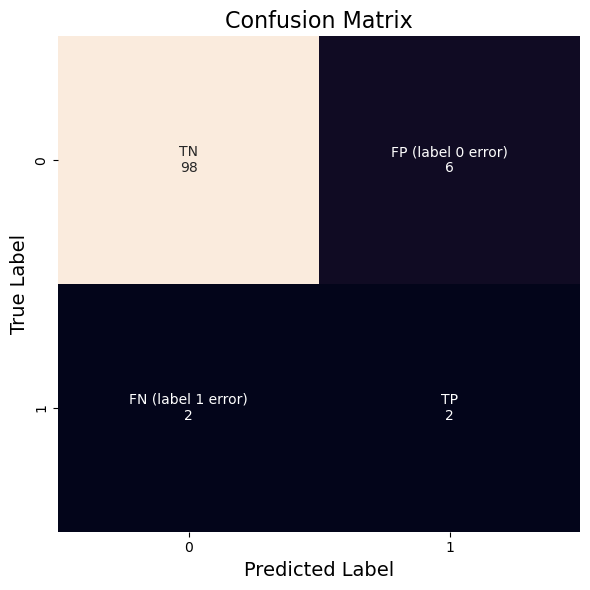

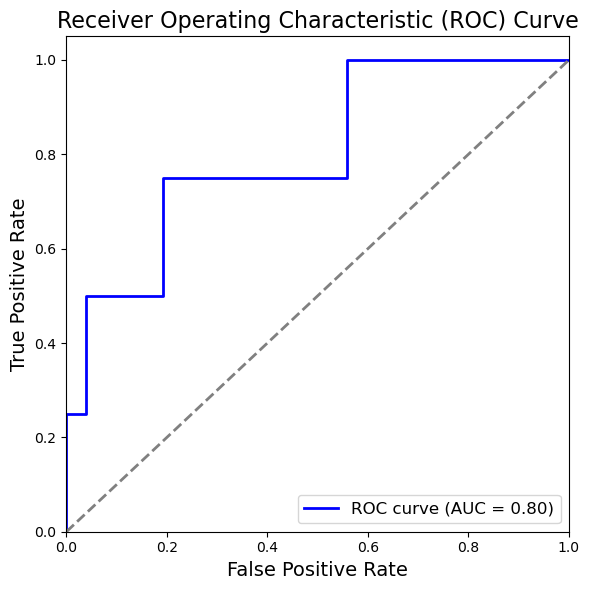

In [78]:
# Load Best Model
best_model = keras.models.load_model('best_model.keras')

# Confusion Matrix
y_pred = best_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

conf_matrix = confusion_matrix(y_test, y_pred_classes)


# Annotation 
group_names = ['TN', 'FP (label 0 error)', 'FN (label 1 error)', 'TP']
group_counts = [value for value in conf_matrix.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (6,6))
sns.heatmap(conf_matrix, annot = labels, fmt = '', cbar = False, color = 'Blue')
plt.title('Confusion Matrix', fontsize = 16)
plt.xlabel('Predicted Label', fontsize = 14)
plt.ylabel('True Label', fontsize = 14)
plt.tight_layout()
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()


fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.legend(loc='lower right', fontsize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.tight_layout()
plt.savefig('ROC_Curve.png', dpi=300)
plt.show()

# 8. Prediction with validation dataset

In [79]:
# Load best deep learning model & validation
y_pred_prob = best_model.predict(x_val_df)

# prediction rate cutoff x > 0.5 : 1
y_pred = (y_pred_prob > 0.5).astype(int)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step


In [80]:
# Check location of DNA Damage High Labeld Data
np.where(y_pred != 0)

(array([  0,   5,  16,  17,  21,  26,  45,  55,  67,  88,  89, 130, 160,
        167, 200, 218, 236, 256, 276, 279, 291, 302, 313], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0], dtype=int64))

In [112]:
# Find Near Data
from sklearn.neighbors import NearestNeighbors

# Choose specific data
specific_data = x_val_df.iloc[[218], :] 

# NearestNeighbors
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(x_val_df)
distances, indices = nbrs.kneighbors(specific_data)

closet_data = x_val_df.iloc[indices[0]]


print(f'Selected Data Index: {specific_data.index[0]}')
print(f'Closest 5 Data Indices: {closet_data.index.tolist()}')

for idx in closet_data.index.tolist():
    value = x_val_meta.loc[idx, 'Metadata_broad_sample']
    print(chem_dat[chem_dat['BROAD_ID'] == value]['CPD_NAME'].tolist()) # 64 DMSO

Selected Data Index: 218
Closest 5 Data Indices: [218, 22, 44, 1, 250]
['TPEN']
['colchicine']
['LE 300']
['isokobusone']
['furazolidone']
